# Optimisation of the charging of a Quantum Battery on IBM Hardware

## Import packages

In [1]:
#importing krotov-related packages
import os
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
from scipy.fftpack import fft
from scipy.interpolate import interp1d
import pickle

font = {'family':'serif'}

In [2]:
#importing IBM-related packages
#qiskit ibm packages
from qiskit import IBMQ, QuantumCircuit, pulse, schedule, transpile
#from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_gate_map, plot_histogram
from qiskit.circuit import QuantumCircuit, Gate, Parameter
from qiskit.tools.jupyter import *

from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()
backend = provider.get_backend('ibm_brisbane')

In [3]:
#IBM backend configurations
backend_config = backend.configuration()
dt = backend.dt
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']
lcm = np.lcm(acquire_alignment, pulse_alignment)
print(lcm)
backend_defaults = backend.defaults()

8


# Optimisation

In [283]:
#Two level Hamiltonian
def hamiltonian(omega=1, ampl0=0.2):
    """Two-level-system Hamiltonian

    Args:
        omega (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
    """
    H0 = -0.5 * omega * qutip.operators.sigmaz()
    H1 = qutip.operators.sigmax()

    def guess_control(t, args):
        return ampl0 * krotov.shapes.flattop(
            t, t_start=0, t_stop=t_c, t_rise=0.3, func="blackman"
        )

    return [H0, [H1, guess_control]]

In [284]:
H = hamiltonian()

In [285]:
def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)

In [287]:
dt_ns=dt*1e9

#Choose your desired gate duration
desired_gate_duration_ns = 30

#Calculates the amount of data points in this gate_duration
desired_data_points = desired_gate_duration_ns/dt_ns

#Finding the closest values which are attainable on the Quantum Hardware
#Due to lcm
data_points = get_closest_multiple_of(desired_data_points,lcm)

#Real charging time in ns
t_c = data_points*dt_ns
print('The implemented gate duration is', t_c, 'ns')
print('(using',data_points,'data points)')

#Create array of tlist 
tlist = np.linspace(0, t_c, data_points)

The implemented gate duration is 32.0 ns
(using 64 data points)


In [409]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse,color=tud_color)
    ax.set_xlabel('τ(ns)',font)
    ax.set_ylabel('Amplitude',font)
    plt.show(fig)

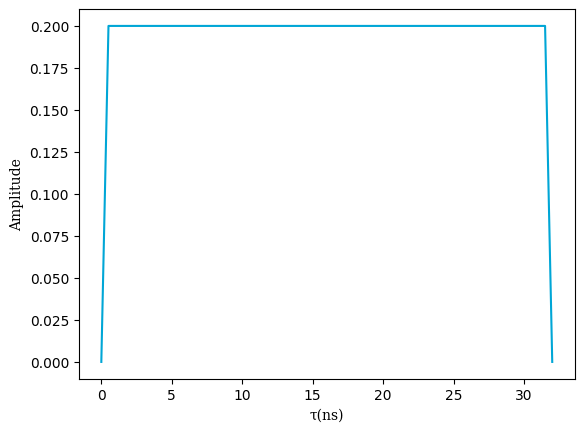

In [410]:
plot_pulse(H[1][1], tlist)

In [290]:
#Optimisation target
objectives = [
    krotov.Objective(
        initial_state=qutip.ket("0"), target=qutip.ket("1"), H=H
    )
]

objectives

[Objective[|Ψ₃₄(2)⟩ to |Ψ₃₅(2)⟩ via [H₃₄[2,2], [H₃₅[2,2], u₁₈(t)]]]]

In [291]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=t_c, t_rise=0.3, t_fall=0.3, func='blackman'
    )

pulse_options = {
    H[1][1]: dict(lambda_a=5, update_shape=S)
}

proj0 = qutip.ket2dm(qutip.ket("0"))
proj1 = qutip.ket2dm(qutip.ket("1"))

guess_dynamics = objectives[0].mesolve(tlist, e_ops=[proj0, proj1])

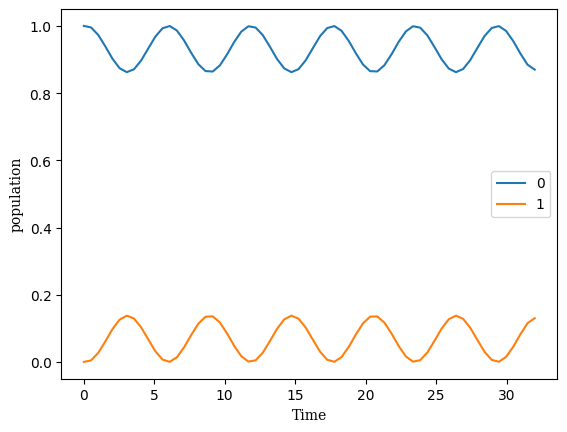

In [292]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('Time',font)
    ax.set_ylabel('population',font)
    plt.show(fig)

plot_population(guess_dynamics)

In [293]:
##Perform the optimisation
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_ss,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    iter_stop=20,
    store_all_pulses=True,
)

iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     9.05e-01    0.00e+00   9.05e-01        n/a        n/a     0
1     3.47e-01    3.15e-02   3.78e-01  -5.58e-01  -5.27e-01     1
2     7.64e-03    3.16e-02   3.92e-02  -3.39e-01  -3.08e-01     1
3     1.59e-04    7.83e-04   9.42e-04  -7.48e-03  -6.70e-03     1


In [294]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2024-02-04 11:50:55
- Number of objectives: 1
- Number of iterations: 3
- Reason for termination: Reached convergence: J_T < 1e-3
- Ended at 2024-02-04 11:51:00 (0:00:05)

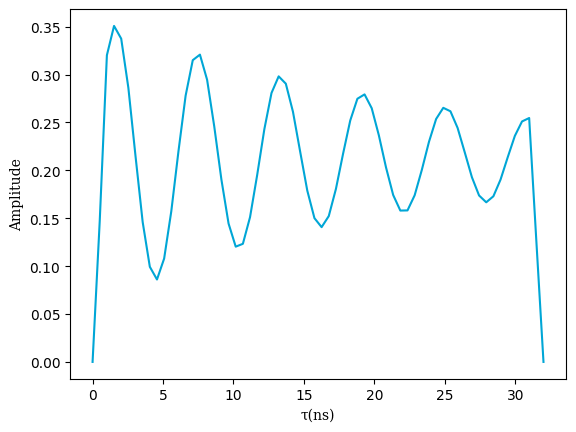

In [411]:
plot_pulse(opt_result.optimized_controls[0], tlist)

In [296]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj0, proj1])

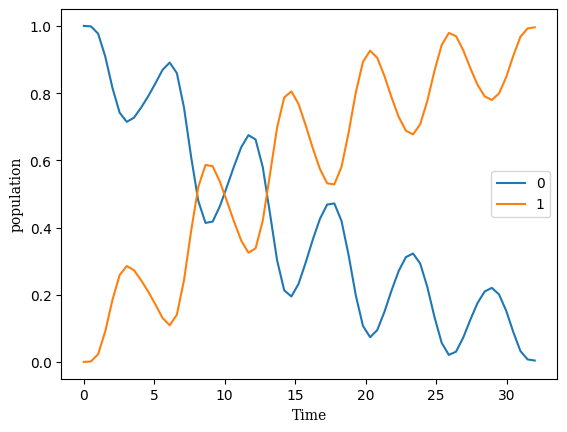

In [297]:
plot_population(opt_dynamics)

In [363]:
# Get the current working directory
current_directory = os.getcwd()

#Specify how to save the file
file_path = os.path.join(current_directory, 'STS-try.pkl')

#save the result to the file
#with open(file_path, 'wb') as file:
#    pickle.dump(np.array(opt_result.optimized_controls[0]), file)

#to open the pulse data
with open(file_path, 'rb') as file:
    opt_pulse = pickle.load(file)

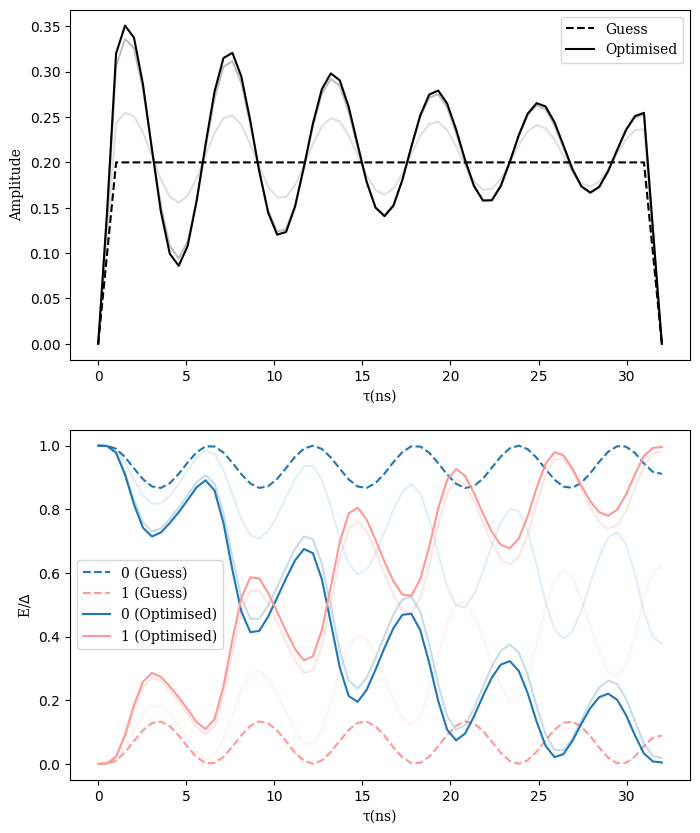

In [413]:
tud_color='#00A6D6'
size = 20
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """
    fig, [ax_ctr, ax_dyn] = plt.subplots(nrows=2, figsize=(8, 10))
    n_iters = len(opt_result.iters)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[proj0, proj1]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'Guess'
            pop_labels = ['0 (Guess)', '1 (Guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'Optimised'
            pop_labels = ['0 (Optimised)', '1 (Optimised)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[0],
            label=pop_labels[0],
            color="#1F77B4",  # colour blue
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[1],
            label=pop_labels[1],
            color='#FF9896',  # colour pink
            ls=ls,
            alpha=alpha,
        )
    ax_dyn.legend(prop=font)
    ax_dyn.set_xlabel('τ(ns)',**font)
    ax_dyn.set_ylabel('E/$\Delta$',**font)
    ax_ctr.legend(prop=font,fontsize=size)
    ax_ctr.set_xlabel('τ(ns)',**font)
    ax_ctr.set_ylabel('Amplitude',**font)
    plt.show(fig)

plot_iterations(opt_result)

In [300]:
opt_pulse=np.array(opt_result.optimized_controls[0])

## Implementation on Quantum Computer using Qiskit Pulse

In [4]:
#specify desired qubit
qubit = 0
#to find the value from our data acquisition
def finding_value(counts):
    total=counts['1']+counts['0']
    return (counts['1'])/total

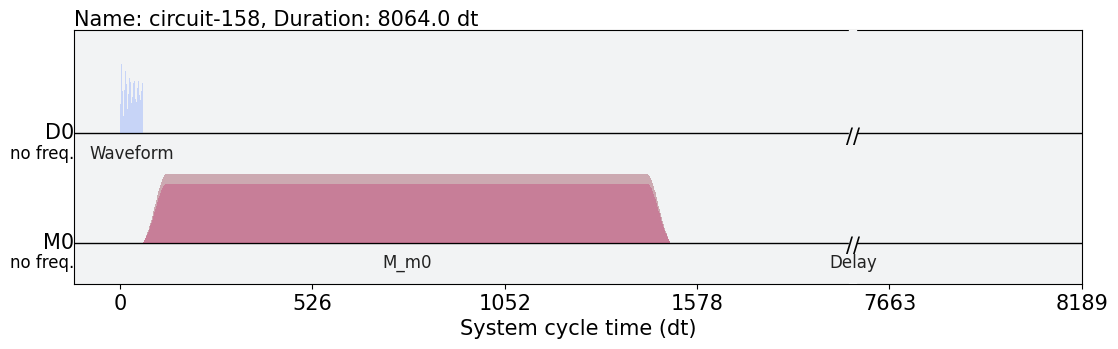

In [353]:
with pulse.build(backend=backend, default_alignment='sequential', name='QB Gate') as QB_Gate:
        drive_chan = pulse.drive_channel(qubit)
        # Drive pulse 
        pulse.play(pulse.library.Waveform(opt_pulse), drive_chan)

circ = QuantumCircuit(1)
custom_gate = Gate('my_custom_gate',1,[])
circ.append(custom_gate,[0])
circ.measure_all()

circ.add_calibration(custom_gate, [0], QB_Gate) 

circ_transpile = transpile(circ, backend)
circ_sched = schedule(circ_transpile, backend)
circ_sched.draw()

In [309]:
job = backend.run(circ_transpile, shots=1024)
IDs = []
IDs.append('JOB_ID')

In [344]:
#create counts for each job
counts1=provider.backend.retrieve_job(IDs[0]).result().get_counts()
print(counts10)

In [3]:
#counts data from our experiments
counts1={'0': 91, '1': 933}
counts2={'0': 94, '1': 930}
counts3={'1': 928, '0': 96}
counts4={'0': 114, '1': 910}
counts5={'1': 922, '0': 102}
counts6={'0': 87, '1': 937}
counts7={'0': 102, '1': 922}
counts8={'1': 953, '0': 71}
counts9={'1': 919, '0': 105}
counts10={'0': 84, '1': 940}

{'0': 114, '1': 910}
0.888671875


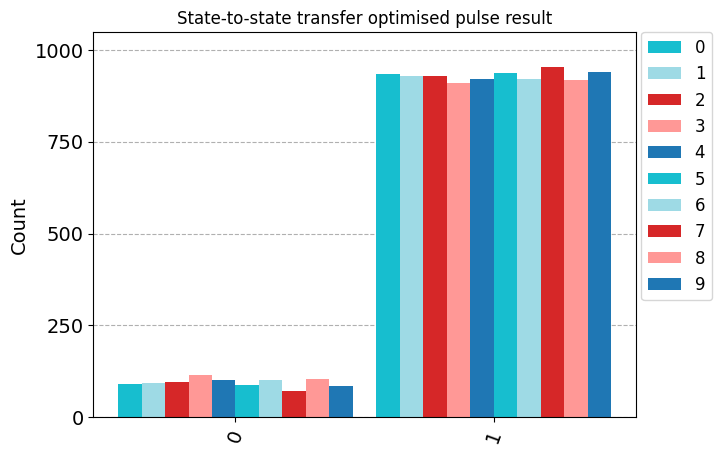

In [41]:
#counts4=provider.backend.retrieve_job('cpzptrv7z1hg00845feg').result().get_counts()
tud_color='#00A6D6'
pink='#FF9896'
blue='#1F77B4'


color1="#17BECF"
color2="#9EDAE5"
color3="#D62728"
color4="#FF9896"
color5="#1F77B4"

legend=['0', '1','2','3','4','5','6','7','8','9']
colors=[color1,color2,color3,color4,color5,color1,color2,color3,color4,color5]

plot_histogram([counts1,counts2,counts3,counts4,counts5,counts6,counts7,counts8,counts9,counts10],legend=legend,title='State-to-state transfer optimised pulse result',color=colors, bar_labels=False)


In [46]:
#Our experimental values
values=[0.9111328125, 0.908203125, 0.90625, 0.888671875, 0.900390625, 0.9150390625, 0.900390625, 0.9306640625, 0.8974609375, 0.91796875]
print(values)

[0.9111328125, 0.908203125, 0.90625, 0.888671875, 0.900390625, 0.9150390625, 0.900390625, 0.9306640625, 0.8974609375, 0.91796875]


In [47]:
np.mean(values)

0.9076171875

In [48]:
std_err=np.std(values) / np.sqrt(np.size(values))
    
print('Standard Error:', std_err)

Standard Error: 0.003570000499223092
